In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

2024-04-08 23:31:50.509227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/kailashkumar/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
captions = pd.read_csv("/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/captions.txt")

captions['image'] = captions['image'].apply(
    lambda x: f'/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/{x}')
captions.head(10)

,image,caption
0,/Users/kailashkumar/Documents/Multi_modal_GenA...,A child in a pink dress is climbing up a set o...
1,/Users/kailashkumar/Documents/Multi_modal_GenA...,A girl going into a wooden building .
2,/Users/kailashkumar/Documents/Multi_modal_GenA...,A little girl climbing into a wooden playhouse .
3,/Users/kailashkumar/Documents/Multi_modal_GenA...,A little girl climbing the stairs to her playh...
4,/Users/kailashkumar/Documents/Multi_modal_GenA...,A little girl in a pink dress going into a woo...
5,/Users/kailashkumar/Documents/Multi_modal_GenA...,A black dog and a spotted dog are fighting
6,/Users/kailashkumar/Documents/Multi_modal_GenA...,A black dog and a tri-colored dog playing with...
7,/Users/kailashkumar/Documents/Multi_modal_GenA...,A black dog and a white dog with brown spots a...
8,/Users/kailashkumar/Documents/Multi_modal_GenA...,Two dogs of different breeds looking at each o...
9,/Users/kailashkumar/Documents/Multi_modal_GenA...,Two dogs on pavement moving toward each other .


In [3]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [4]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head(10)

,image,caption
0,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a child in a pink dress is climbing up...
1,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a girl going into a wooden building [end]
2,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a little girl climbing into a wooden p...
3,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a little girl climbing the stairs to h...
4,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a little girl in a pink dress going in...
5,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a black dog and a spotted dog are figh...
6,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a black dog and a tricolored dog playi...
7,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] a black dog and a white dog with brown...
8,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] two dogs of different breeds looking a...
9,/Users/kailashkumar/Documents/Multi_modal_GenA...,[start] two dogs on pavement moving toward eac...


In [5]:
captions.count()

image      40455
caption    40455
dtype: int64

In [7]:
small_captions = captions[:5000]
small_captions.count()

image      5000
caption    5000
dtype: int64

[start] man on electric scooter looking at shelves of shoes [end]



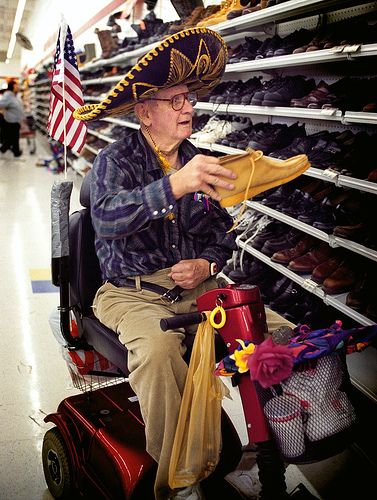

In [8]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)

print()

im = Image.open(random_row.image)
im

In [10]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

## Tokenize

In [11]:
tokenizer = tf.keras.layers.TextVectorization(
                                            max_tokens = VOCABULARY_SIZE,
                                            standardize = None,
                                            output_sequence_length = MAX_LENGTH)

tokenizer.adapt(small_captions['caption'])

2024-04-08 23:34:42.197437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
word2idx = tf.keras.layers.StringLookup(
                                        mask_token = "",
                                        vocabulary = tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
                                        mask_token="",
                                        vocabulary=tokenizer.get_vocabulary(),
                                        invert=True)

In [13]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(small_captions['image'], small_captions['caption']):
    img_to_cap_vector[img].append(cap)
    
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_trainkeys, img_name_valkeys = (img_keys[:slice_index],
                                       img_keys[slice_index:])

train_imgs = []
train_captions = []

for i in img_name_trainkeys:
    capt_len = len(img_to_cap_vector[i])
    train_imgs.extend([i] * capt_len)
    train_captions.extend(img_to_cap_vector[i])

val_imgs = []
val_captions = []

for i in img_name_valkeys:
    capt_len = len(img_to_cap_vector[i])
    val_imgs.extend([i] * capt_len)
    val_captions.extend(img_to_cap_vector[i])
    
val_imgs[:5], val_captions[:5]

(['/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg',
  '/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg',
  '/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg',
  '/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg',
  '/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg'],
 ['[start] a boy hitting a soccer ball with his chest [end]',
  '[start] a child is hitting a soccer ball with their chest [end]',
  '[start] a child is playing soccer with a blue and white soccer ball nearby onlookers [end]',
  '[start] the boy hits the blue and white soccer ball with his knee [end]',
  '[start] the boy is kicking a soccer ball [end]'])

In [14]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(4000, 4000, 1000, 1000)

(500, 336)


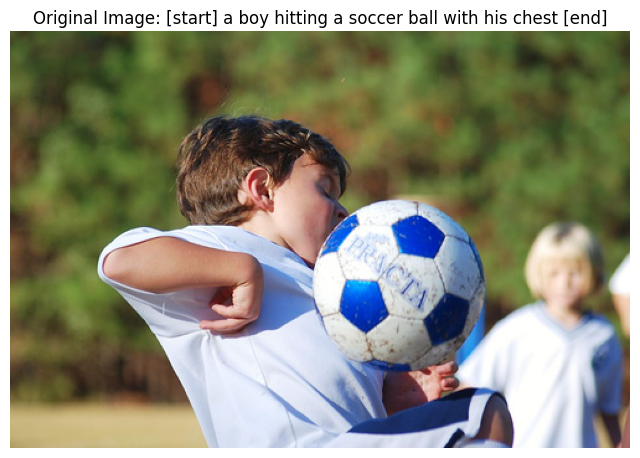

caption is [   3    2   15 1226    2  161   57   11   26 1059    4    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]

(299, 299, 3)


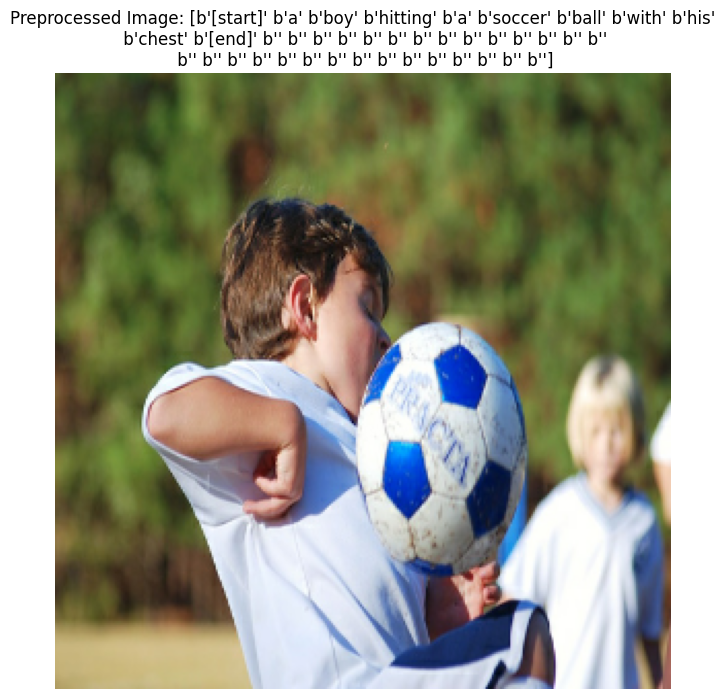

In [16]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32) / 255.0
    caption = tokenizer(caption)
    print(f"caption is {caption}")
    return img, caption

paths = '/Users/kailashkumar/Documents/Multi_modal_GenAI_w6/flickr_dataset/Images/1680126311_b92a2e8e72.jpg'
texty = '[start] a boy hitting a soccer ball with his chest [end]'


def visualize_before(img_path, caption):
    img = Image.open(img_path)
    print(img.size)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Original Image: {caption}")
    plt.axis("off")
    plt.show()

def visualize_after(img, caption):
    print(img.shape)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Preprocessed Image: {idx2word(caption)}")
    plt.axis("off")
    plt.show()
    
visualize_before(paths, texty) 
img, caption = load_data(paths, texty)
print()
visualize_after(img, caption)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

caption is Tensor("text_vectorization/Pad:0", shape=(None,), dtype=int64)
caption is Tensor("text_vectorization/Pad:0", shape=(None,), dtype=int64)


In [18]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [19]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [20]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training)

        x = self.layer_norm_2(x + attn_output)
        return x

In [21]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [22]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 40, 512])

In [24]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [25]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [26]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 [==============================] - 9s 0us/step


In [27]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=cross_entropy)

history = caption_model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
    callbacks=[early_stopping])

Epoch 1/3


  6/125 [>.............................] - ETA: 22:27 - loss: 6.7849 - acc: 0.0829

In [ ]:
idx2word(2).numpy().decode('utf-8')

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2j6yclbKYDav4BGUKLAdTvSFXp1gtuzy5DQ&usqp=CAU"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)
print()

In [ ]:
# caption_model.save_weights('image_captioning_transformer_weights.h5')

# if not load_weights:
#     from google.colab import drive
#     drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())